# 2 - Models and Training
In this notebook we show how to load the dataset, load the different models (both learned and model based as a TF-graph), and train the models on the dataset.

In [1]:
%load_ext autoreload
%autoreload 2
import os

# because of the large (sparse) matrices, the gpu memory can get maxed out pretty quickly, resulting in errors like: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.
# to prevent this, you can disable/enable gpu completely by (un)commenting the following line
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import numpy as np
from src.config.config import DatasetConfig, ModelConfig, Config, TrainingConfig
from src.data.load import load_datasets
from src.models.training import train_from_config
from src.models.load import load_model
import matplotlib.pyplot as plt
from src.data.grid import create_grid_transformation_matrices

from src.visualisation.visualise import plot_poloidal_cs

## Load dataset and visualise sample

In [2]:
# define data configurations
geometry_id = "65903_cam_10"
data_config = DatasetConfig(geometry_id=geometry_id, batch_size=1)

# load datasets
train_ds, val_ds, test_ds = load_datasets(data_config)

rect_to_tri, tri_to_rect = create_grid_transformation_matrices(geometry_id, (256, 256))

Metal device set to: Apple M1 Max


2022-11-06 16:43:18.542441: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-06 16:43:18.542595: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2022-11-06 16:43:26.520516: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


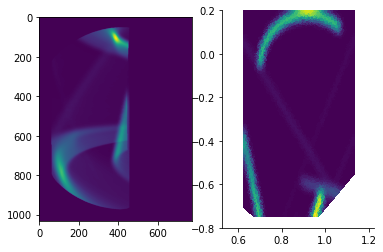

In [3]:
sample_image, sample_inversion = train_ds.__iter__().next()
sample_inversion_tri = rect_to_tri @ np.reshape(sample_inversion, -1)

input_shape = (sample_image.shape[1], sample_image.shape[2])
output_shape = (sample_inversion.shape[1], sample_inversion.shape[2])

fig, axs = plt.subplots(1, 2)
axs[0].imshow(sample_image[0])
plot_poloidal_cs(sample_inversion_tri, axs[1])

## Load model architectures (model-based)

In [4]:
sirt_model_config = ModelConfig(name="sirt", geometry_id="65903_cam_10", n_iterations=100, mu=2.)
gd_model_config = ModelConfig(name="gradient_descent", geometry_id="65903_cam_10", n_iterations=100, mu=0.02)

sirt_model_config.set_shape_from_ds(train_ds)
gd_model_config.set_shape_from_ds(train_ds)

In [5]:
sirt_model = load_model(sirt_model_config)
sirt_model.compile(metrics=['mse', 'mae'])

In [6]:
gd_model = load_model(gd_model_config)
gd_model.compile(metrics=['mse', 'mae'])

In [7]:
sirt_inversion_est = sirt_model(sample_image)
gd_inversion_est = gd_model(sample_image)

sirt_inversion_est_tri = rect_to_tri @ np.reshape(sirt_inversion_est, -1)
gd_inversion_est_tri = rect_to_tri @ np.reshape(gd_inversion_est, -1)

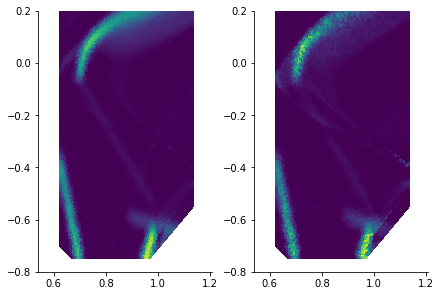

In [8]:
fig, axs = plt.subplots(1, 2, constrained_layout=True)
plot_poloidal_cs(sirt_inversion_est_tri, axs[0])
plot_poloidal_cs(gd_inversion_est_tri, axs[1])

## Load model architectures (learned)

In [9]:
unet_sirt_informed_config = ModelConfig(name="unet_backprojection", geometry_id="65903_cam_10")
unet_sirt_informed_config.set_shape_from_ds(train_ds)

unet_sirt_informed = load_model(unet_sirt_informed_config)
unet_sirt_informed.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

unet_sirt_informed.fit(train_ds.take(10))

2022-11-06 16:44:32.005203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 8s 463ms/step - loss: 0.4495 - mse: 0.4495 - mae: 0.3324


In [10]:
learned_proximal_sirt_config = ModelConfig(name="deep_unfolded_proximal_sirt", geometry_id="65903_cam_10", n_iterations=5, encoder_filters=[8, 8, 16, 32], decoder_filters=[32, 16, 8, 8], bottleneck_filters=[32], unfolded_intermediate_output_loss = True)
learned_proximal_sirt_config.set_shape_from_ds(train_ds)

learned_proximal_sirt = load_model(learned_proximal_sirt_config)
learned_proximal_sirt.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

learned_proximal_sirt.fit(train_ds.take(10))

2022-11-06 16:45:07.704766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 27s 1s/step - loss: 7.0220 - reshape_8_loss: 1.1568 - instance_normalization_20_loss: 1.2024 - instance_normalization_29_loss: 1.1795 - instance_normalization_38_loss: 1.1652 - instance_normalization_47_loss: 1.1613 - instance_normalization_56_loss: 1.1568 - reshape_8_mse: 1.1568 - reshape_8_mae: 0.6813 - instance_normalization_20_mse: 1.2024 - instance_normalization_20_mae: 0.7282 - instance_normalization_29_mse: 1.1795 - instance_normalization_29_mae: 0.6945 - instance_normalization_38_mse: 1.1652 - instance_normalization_38_mae: 0.6666 - instance_normalization_47_mse: 1.1613 - instance_normalization_47_mae: 0.6792 - instance_normalization_56_mse: 1.1568 - instance_normalization_56_mae: 0.6813


## Single config and train function

In [11]:
training_config = TrainingConfig(epochs=1)
config = Config(dataset=data_config, model=unet_sirt_informed_config, training=training_config)

In [12]:
train_from_config(config)

2022-11-06 16:45:55.853159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 0.1574 - mae: 0.1842 - mse: 0.1574

2022-11-06 16:46:45.604288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 61s 562ms/step - loss: 0.1574 - mae: 0.1842 - mse: 0.1574 - val_loss: 0.1361 - val_mae: 0.1520 - val_mse: 0.1361
